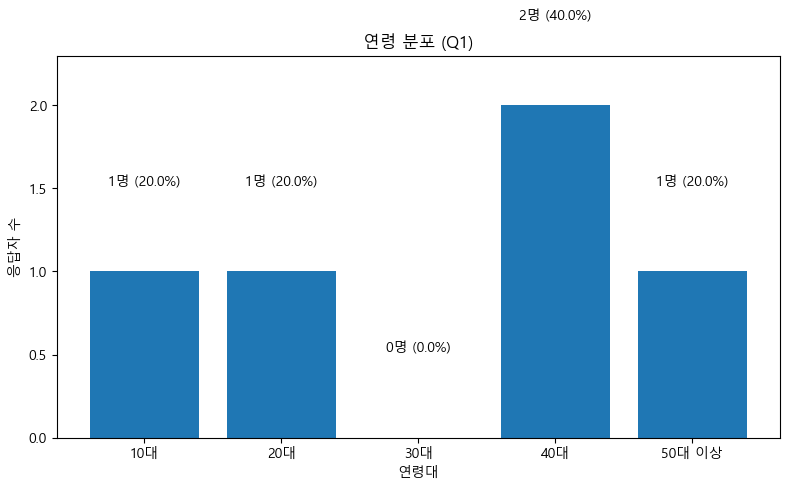

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import platform
from pathlib import Path

#응답자의 연령대 구성 확인. 특정 연령대에 집중되어 있는지, 균등 분포인지 파악 가능

# ===== 0) 환경 설정: 한글 폰트 =====
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# ===== 1) 데이터 로드 =====
file_path = '../data/survey/raw/2024_만족도조사.csv'
# 인코딩 자동 처리(UTF-8-SIG → CP949 순차 시도)
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp949')

# ===== 2) 연령(Q1) 라벨 매핑 및 전처리 =====
age_map = {
    1: '10대',
    2: '20대',
    3: '30대',
    4: '40대',
    5: '50대 이상'
}
order = ['10대', '20대', '30대', '40대', '50대 이상']

# 숫자형 변환(문자/공백 섞임 대비)
df['Q1'] = pd.to_numeric(df['Q1'], errors='coerce')
df['연령대'] = df['Q1'].map(age_map)

# 카테고리 순서 고정
df['연령대'] = pd.Categorical(df['연령대'], categories=order, ordered=True)

# 결측/유효값 처리
df_age = df.dropna(subset=['연령대']).copy()

# ===== 3) 분포 집계 =====
counts = df_age['연령대'].value_counts().reindex(order).fillna(0).astype(int)
percent = (counts / counts.sum() * 100).round(1)

# ===== 4) 시각화(막대; 카테고리형 "히스토그램" 대체) =====
plt.figure(figsize=(8, 5))
bars = plt.bar(order, counts.values)

# 막대 위 라벨(개수/비율)
for bar, c, p in zip(bars, counts.values, percent.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts.max()*0.02, 0.5),
             f'{c}명 ({p}%)', ha='center', va='bottom', fontsize=10)

plt.title('연령 분포 (Q1)')
plt.xlabel('연령대')
plt.ylabel('응답자 수')
plt.ylim(0, counts.max() * 1.15 if counts.max() > 0 else 1)
plt.tight_layout()
plt.show()


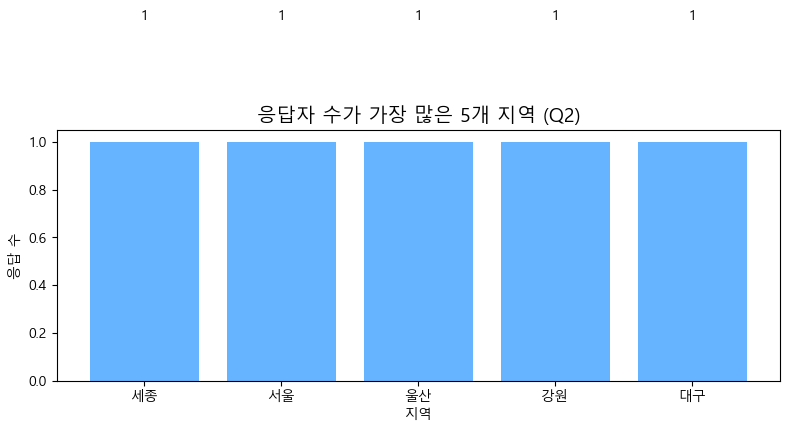

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

#응답자가 주로 분포한 지역 파악

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로
file_path = r'../data/survey/raw/2024_만족도조사.csv'

# CSV 불러오기 (인코딩 자동 처리)
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp949')

# Q2 코드 → 지역명 매핑
region_map = {
    1: '서울', 2: '부산', 3: '대전', 4: '인천', 5: '대구', 6: '광주', 7: '울산', 8: '세종',
    9: '경기', 10: '강원', 11: '충북', 12: '충남', 13: '전북', 14: '전남', 15: '경북', 16: '경남', 17: '제주'
}
df['지역'] = df['Q2'].map(region_map)

# 지역별 응답 수 집계
region_counts = df['지역'].value_counts().head(5)  # 상위 5개 지역

# 시각화
plt.figure(figsize=(8, 5))
bars = plt.bar(region_counts.index, region_counts.values, color='#66b3ff')

# 값 표시
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{bar.get_height()}', ha='center', va='bottom', fontsize=10)

plt.title('응답자 수가 가장 많은 5개 지역 (Q2)', fontsize=14)
plt.xlabel('지역')
plt.ylabel('응답 수')
plt.tight_layout()
plt.show()


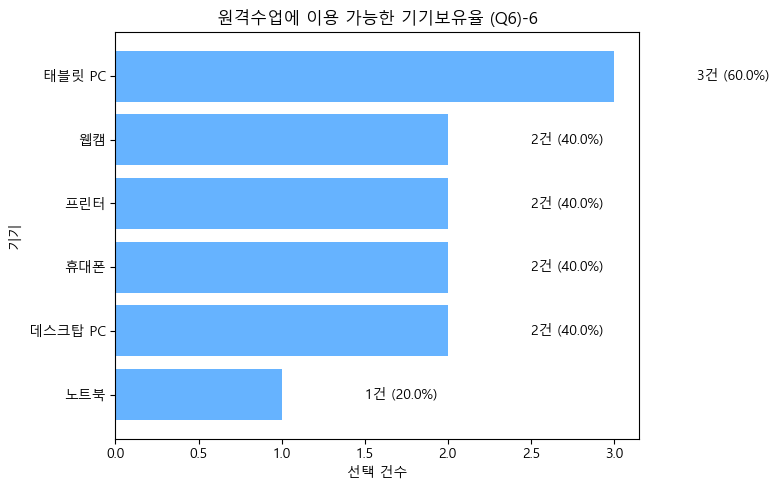

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import platform

#응답자가 가장 많이 사용하는 기기 유형 파악 혹은 이용 가능한 기기 보유율 파악

# -------------------------
# 0) 한글 폰트 설정
# -------------------------
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# -------------------------
# 1) 데이터 로드
# -------------------------
file_path = r'../data/survey/raw/2024_만족도조사.csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp949')

# -------------------------
# 2) Q6 다중선택 파싱
#   - "1, 2, 3" 형태를 정수 리스트로 변환
# -------------------------
def parse_multi(x):
    if pd.isna(x):
        return []
    s = str(x).replace(';', ',')
    parts = [p.strip() for p in s.split(',') if p.strip() != '']
    out = []
    for p in parts:
        try:
            out.append(int(p))
        except ValueError:
            pass
    return out

codes_series = df['Q6'].apply(parse_multi).explode().dropna()
codes_series = codes_series.astype(int)

# -------------------------
# 3) 코드 → 라벨 매핑
# -------------------------
device_map = {
    1: '데스크탑 PC',
    2: '노트북',
    3: '휴대폰',
    4: '태블릿 PC',
    5: '프린터',
    6: '웹캠',
    7: '기타'
}
names = codes_series.map(device_map)

# -------------------------
# 4) 집계: 빈도 & 선택률
#   - 선택률 분모: 유효 응답자 수(Q6에 하나라도 응답한 사람)
# -------------------------
counts = names.value_counts()
n_valid = (df['Q6'].apply(lambda x: len(parse_multi(x)) > 0)).sum()
rates = (counts / n_valid * 100).round(1) if n_valid > 0 else counts*0

# TOP-N 선택 (원하면 값 변경)
TOP_N = min(6, len(counts))
counts_top = counts.head(TOP_N).sort_values(ascending=True)     # 막대 아래→위 오름차순
rates_top  = rates.loc[counts_top.index]

# -------------------------
# 5) 시각화 (수평 막대)
# -------------------------
plt.figure(figsize=(8, 5))
bars = plt.barh(counts_top.index, counts_top.values, color='#66b3ff')

# 막대 라벨: "건수 (선택률%)"
for bar, c, r in zip(bars, counts_top.values, rates_top.values):
    plt.text(bar.get_width() + max(counts_top.max()*0.02, 0.5),
             bar.get_y() + bar.get_height()/2,
             f'{c}건 ({r}%)', va='center', ha='left', fontsize=10)

plt.title(f'원격수업에 이용 가능한 기기보유율 (Q6)-{TOP_N}')
plt.xlabel('선택 건수')
plt.ylabel('기기')
plt.tight_layout()
plt.show()


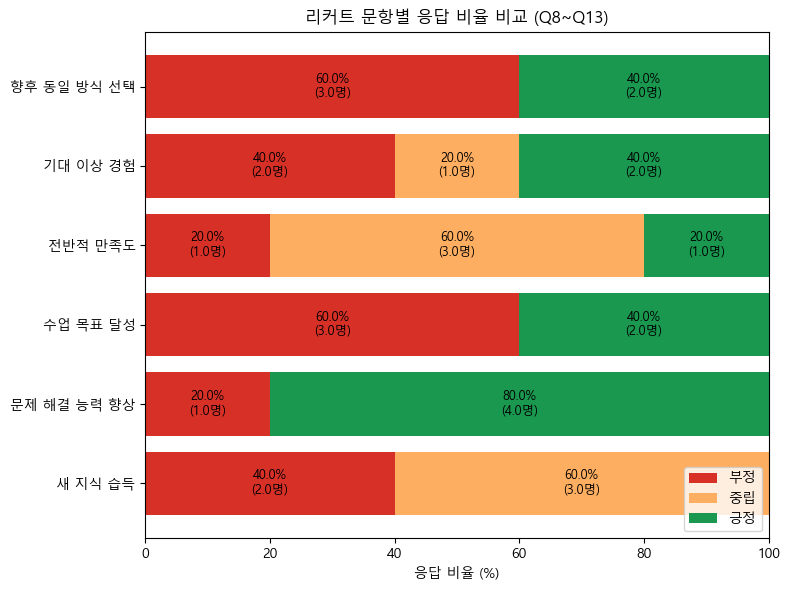

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import platform

#각 문항에 대한 긍/부정 응답의 균형과 강도 파악

# -------------------------
# 한글 폰트 설정
# -------------------------
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# -------------------------
# 데이터 로드
# -------------------------
file_path = r'../data/survey/raw/2024_만족도조사.csv'
try:
    df = pd.read_csv(file_path, encoding='utf-8-sig')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='cp949')

# -------------------------
# Q8~Q13 문항 선택
# -------------------------
likert_cols = ['Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13']

question_labels = {
    'Q8': '새 지식 습득',
    'Q9': '문제 해결 능력 향상',
    'Q10': '수업 목표 달성',
    'Q11': '전반적 만족도',
    'Q12': '기대 이상 경험',
    'Q13': '향후 동일 방식 선택'
}

# -------------------------
# 비율 및 개수 계산
# -------------------------
plot_data = pd.DataFrame(index=likert_cols, columns=['부정', '중립', '긍정'], dtype=float)
count_data = pd.DataFrame(index=likert_cols, columns=['부정', '중립', '긍정'], dtype=int)

for col in likert_cols:
    counts = df[col].value_counts(normalize=False)  # 개수
    counts_pct = df[col].value_counts(normalize=True) * 100  # 비율(%)
    
    neg_count = counts.get(1, 0) + counts.get(2, 0)
    neu_count = counts.get(3, 0)
    pos_count = counts.get(4, 0) + counts.get(5, 0)

    neg_pct = counts_pct.get(1, 0) + counts_pct.get(2, 0)
    neu_pct = counts_pct.get(3, 0)
    pos_pct = counts_pct.get(4, 0) + counts_pct.get(5, 0)
    
    plot_data.loc[col] = [neg_pct, neu_pct, pos_pct]
    count_data.loc[col] = [neg_count, neu_count, pos_count]

# -------------------------
# 시각화
# -------------------------
fig, ax = plt.subplots(figsize=(8, 6))
y_pos = np.arange(len(plot_data))

neg_bar = ax.barh(y_pos, plot_data['부정'], color='#d73027', label='부정', align='center')
neu_bar = ax.barh(y_pos, plot_data['중립'], left=plot_data['부정'], color='#fdae61', label='중립', align='center')
pos_bar = ax.barh(y_pos, plot_data['긍정'], left=plot_data['부정'] + plot_data['중립'],
                  color='#1a9850', label='긍정', align='center')

# 퍼센트 + 개수 라벨 추가
for bars, category in zip([neg_bar, neu_bar, pos_bar], ['부정', '중립', '긍정']):
    for i, bar in enumerate(bars):
        width = bar.get_width()
        count = count_data.iloc[i][category]
        if width > 0:
            ax.text(bar.get_x() + width / 2, 
                    bar.get_y() + bar.get_height()/2,
                    f'{width:.1f}%\n({count}명)',
                    ha='center', va='center', color='black', fontsize=9)

ax.set_yticks(y_pos)
ax.set_yticklabels([question_labels[q] for q in plot_data.index])
ax.set_xlabel('응답 비율 (%)')
ax.set_title('리커트 문항별 응답 비율 비교 (Q8~Q13)')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()
